# Financial Fraud Detection 

For this project, I would like to investigate methods for financial fraud detection. This usecase of machine learning is extremely important as daily financial transactions are numbered to great to do any by hand analysis in real time. Banks and other financial institutions must resort to machine learning methods in conjuction with hard rules in order to efficiently detect fraud and stop a transaction before it happens. Success in doing so is about balancing the precision and recall of these methods so that customers are secure, but also don't have to constantly have their transactions blocked. 

### Unsupervised Preprocessing for Boosting Supervised Model Performance

The main investigation for this project is checking weather unsupervised techniques can be used to boost supervised machine learning performance when classifying fraudulent transactions.


Module Import:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier


Public financial data is a little hard to come by due to the security, and therefore I will use a generated dataset instead. This data comes from a financial transaction generator called PaySim, and was originally generated for fraud detection research[1]. The dataset itself is downsampled to 1/4 of it's original size and made available by one of the paper's authors on Kaggle. The generator mimics real underlining data, however it strips away sensitive information. This specific dataset is based off of mobile banking transactions happening within Africa. Customers have balances in these apps, which can be sent to other people, banks, or merchants. 
#### Data Import:


In [3]:
data_full = pd.read_csv('data/paysim_data_v2.csv')

### EDA - Features Descriptions and Plots



In [4]:
data_full.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Column Descriptors:
These are just taken straight from the Kaggle page:

| Feature          | Description                                                                                                                                       |
|------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **step**         | Maps a unit of time in the real world. In this case, 1 step is 1 hour of time. Total steps 744 (30 days simulation).                              |
| **type**         | Type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.                                                                                                  |
| **amount**       | Amount of the transaction in local currency.                                                                                                      |
| **nameOrig**     | Customer who started the transaction.                                                                                                             |
| **oldbalanceOrg**| Initial balance before the transaction.                                                                                                           |
| **newbalanceOrig**| New balance after the transaction.                                                                                                               |
| **nameDest**     | Customer who is the recipient of the transaction.                                                                                                 |
| **oldbalanceDest**| Initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).                 |
| **newbalanceDest**| New balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).                      |
| **isFraud**      | Transactions made by the fraudulent agents inside the simulation. Fraudulent agents aim to profit by taking control of customers' accounts and try to empty the funds by transferring to another account and then cashing out of the system.|
| **isFlaggedFraud**| The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.|

Here are some of the basic properties of this dataset:

In [5]:
data_full.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


We do imediately have some clean up to do with the **isFlaggedFraud** feature. These transactions are simulated as if caught, and no balance is transfered. Therefore the **oldbalanceOrg**, **newbalanceOrig**, **oldbalanceDest**, and **newbalanceDest** will contribute any information to the fraud detection. We can examine this by checking the corroleation of these 4 features, when **isFlaggedFraud** is True.

In [6]:
data_full.loc[data_full['isFlaggedFraud'] == 1].head()
# All balances are the same when a transaction is canceled due to simulation.

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1


This situation is a hard cutoff where any transaction above 200,000 is auto canceled and considered fraud. It's important to have a catch like this, but it can be hardcoded in (ie any transaction over a certain amount is fraud), so I'll just remove these instances from the dataset. There are only 16 of them anyways.

In [7]:
print(data_full.loc[data_full['isFlaggedFraud'] == 1].shape) # Shows only 16 instances
data_full = data_full.loc[data_full['isFlaggedFraud'] != 1]
data_full.drop(columns='isFlaggedFraud', inplace=True) # No reason to keep this feature around

(16, 11)


Next, I'll take a look at the distribution of the different transaction types, along with how frequent fraudulent transactions occur within each of these categories.

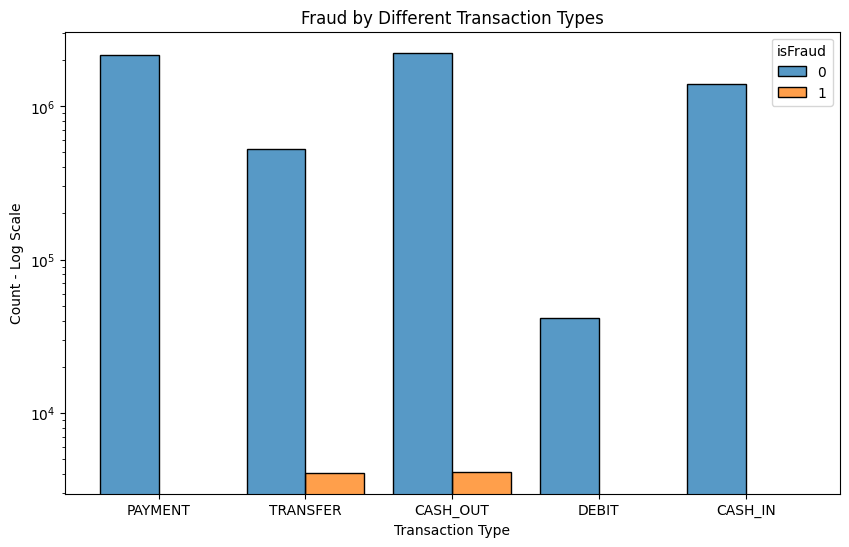

In [8]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(
    data=data_full,
    x='type',
    hue='isFraud',  # Differentiate between fraud and non-fraud transactions
    multiple='dodge',  # Place histograms side by side for comparison
    shrink=0.8, # Adjust the width of the bars
)
# Add title and labels
plt.title('Fraud by Different Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count - Log Scale')
plt.yscale('log')
# Show the plot
plt.show()

The **TRANSFER** and **CASH_OUT** types are the only ones in this dataset that fraudulent charges occur. As a result, we can drop the other 3 transactions types from the database. In the real world, it makes sense that fraud is very unlikely for these transaction types anyway, so this can be another hardcoded feature of our model when processing new data. Fraudulent transactions are also a significantly smaller order of magnitude in occurance (Almost 3 orders of magnitude) than normal transactions, which is what we would expect. This unbalanced dataset can be leveraged in unsupervised learning, but may need to be addressed for supervised learning when considering what score will be prioritiesed (accuracy, precision, recall, etc...)

In [9]:
data_full = data_full.loc[(data_full['type'] == 'TRANSFER') | (data_full['type'] == 'CASH_OUT')] # Keep only TRANSFER AND CASH_OUT transactions

Another thing to take a look at is the **nameOrig** and **nameDest** fields. These identifiers for the customer, but what is important here is more so the customer type, which is identified by the first character. Let's take a look at the different types:

In [10]:
data_full['nameOrig'] = data_full['nameOrig'].apply(lambda x: x[0])
data_full['nameDest'] = data_full['nameDest'].apply(lambda x: x[0])

print("Unique Origin Customer Types:", data_full['nameOrig'].unique())
print("Unique Destination Customer Types:", data_full['nameDest'].unique())

Unique Origin Customer Types: ['C']
Unique Destination Customer Types: ['C']


There were at least merchant types before, but both types are now showing regular customers when we consider only the **TRANSFER** and **CASH_OUT** transaction types. Since this adds no information, we can just drop these features.

In [11]:
data_full.drop(columns=['nameOrig', 'nameDest'], inplace=True)

Another thing that can be looked at is the time component. The **step** feature represents how many hours in the simulation have passed when a transaction was initiated. Let's take a look at the breakdown of fraudulent transactions vs valid ones:

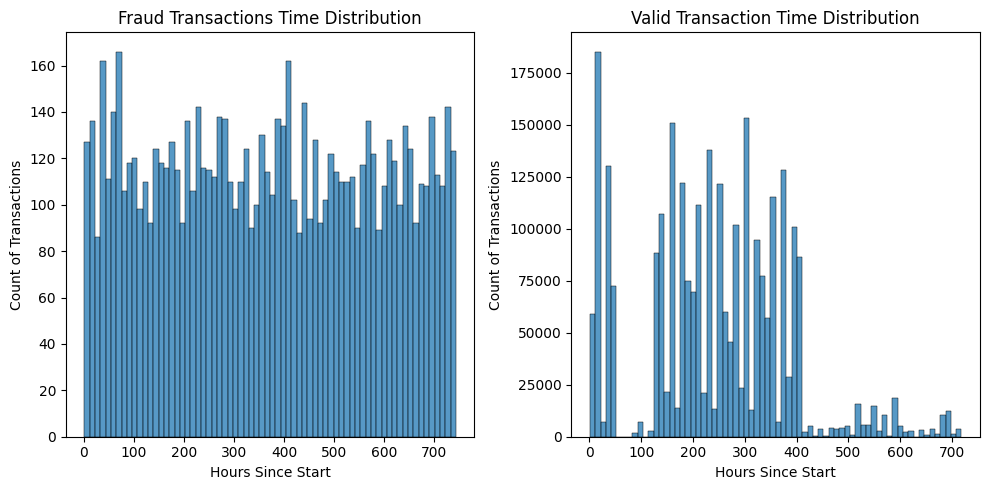

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data_full.loc[data_full['isFraud'] == 1],
    x = 'step',
    ax=ax1,
    bins=70
)
ax1.set_title('Fraud Transactions Time Distribution')
ax1.set_xlabel('Hours Since Start')
ax1.set_ylabel('Count of Transactions')
# Show the plot
sns.histplot(
    data_full.loc[data_full['isFraud'] == 0],
    x = 'step',
    ax=ax2,
    bins=70
)
ax2.set_title('Valid Transaction Time Distribution')
ax2.set_xlabel('Hours Since Start')
ax2.set_ylabel('Count of Transactions')

plt.tight_layout()
plt.show()

We can see there is a fairly large distribution discrepency over time between valid and fraudulent transactions. Because of this, the **step** feature will likely be a useful one once modeling begins. Another feature that can be considered is also at what point in the 24 hour day a transaction occurs. We can get this result by taking mod 24 of the **step** feature. The data doesn't say exactly what time of day the simulation starts, but we can be certain the the 24 hours buckets are being compared correctly.

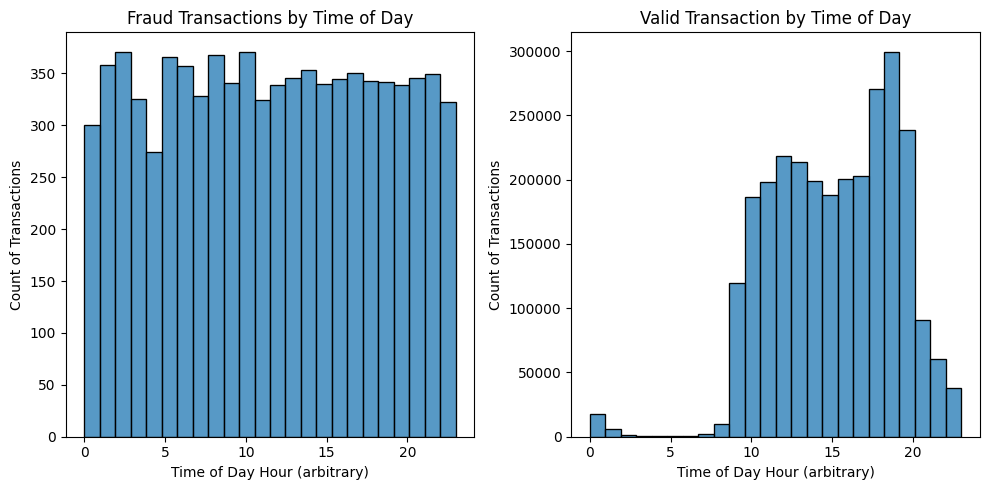

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data_full.loc[data_full['isFraud'] == 1, ['step']].apply(lambda x: x % 24),
    x = 'step',
    ax=ax1,
    bins=24
)
ax1.set_title('Fraud Transactions by Time of Day')
ax1.set_xlabel('Time of Day Hour (arbitrary)')
ax1.set_ylabel('Count of Transactions')
# Show the plot
sns.histplot(
    data_full.loc[data_full['isFraud'] == 0, ['step']].apply(lambda x: x % 24),
    x = 'step',
    ax=ax2,
    bins=24
)
ax2.set_title('Valid Transaction by Time of Day')
ax2.set_xlabel('Time of Day Hour (arbitrary)')
ax2.set_ylabel('Count of Transactions')

plt.tight_layout()
plt.show()

The new feature **step** mod 24 ie **time_of_day** also has a fairly different distribution across valid and fraudulent transactions, and therefore I will add this feature into the data.

In [14]:
data_full['time_of_day'] = data_full['step'].apply(lambda x: x % 24)
data_full

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,time_of_day
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,1
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,1
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,1
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,1
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,23
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,23
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,23
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,23


At this point I started to realize that there were some issues with the balance columns. The difference in the balances don't always add up, and additionally, while examining the data further I ran into this assumption which I had missed: 


***Important Note***: Transactions identified as fraudulent are annulled. Hence, for fraud detection analysis, the following columns should not be utilized: newbalanceOrig, newbalanceDest.

So I'll drop these two columns entirely.




In [15]:
data_full.drop(columns=['newbalanceOrig', 'newbalanceDest'], inplace=True)

I'm keeping the **oldbalanceOrg** and the **oldbalanceDest** as these can provide context for the differences between the two customer accounts. Namely, I'm interested in the relative difference between these two accounts, so I'll also feature engineer a **relative_balance_feature** as so:

**relative_balance_feature** = $\frac{|\textbf{oldbalanceDest} - \textbf{oldbalanceOrg} - 1|}{\textbf{oldbalanceOrg} + 1} + 1$

I'm adding the $+1$ so that division by zero is not encountered, and so all numbers are strictly greater than zero.

In [16]:
data_full['relative_balance'] = abs(data_full['oldbalanceDest'] - data_full['oldbalanceOrg'] - 1) / (data_full['oldbalanceOrg'] + 1) + 1

Let's take a look if there is any difference in the distributions with this new **relative_balance** feature:

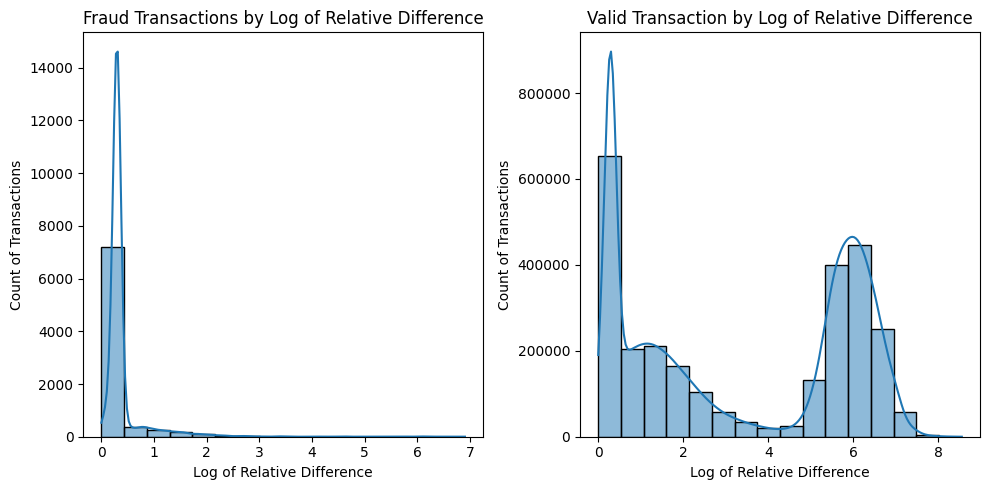

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data_full.loc[data_full['isFraud'] == 1, ['relative_balance']].apply(lambda x: np.log10(x)),
    x = 'relative_balance',
    ax=ax1,
    bins=16,
    kde=True
)
ax1.set_title('Fraud Transactions by Log of Relative Difference')
ax1.set_xlabel('Log of Relative Difference')
ax1.set_ylabel('Count of Transactions')
# Show the plot
sns.histplot(
    data_full.loc[data_full['isFraud'] == 0, ['relative_balance']].apply(lambda x: np.log10(x)),
    x = 'relative_balance',
    ax=ax2,
    bins=16,
    kde=True
)
ax2.set_title('Valid Transaction by Log of Relative Difference')
ax2.set_xlabel('Log of Relative Difference')
ax2.set_ylabel('Count of Transactions')

plt.tight_layout()
plt.show()

We can see from above that most fraud transactions have very similar accounts balances for the origin and destinations accounts, whereas with valid transactions, this still happens, however there also exist a decent distribution of much larger differences, ie destination balance is much larger than original balance.

Finally, let's take a look at the correlation between our features:

In [18]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770393 entries, 2 to 6362619
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   oldbalanceOrg     float64
 4   oldbalanceDest    float64
 5   isFraud           int64  
 6   time_of_day       int64  
 7   relative_balance  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 190.2+ MB


The **type** feature can be one hot encoded before we proceed:

In [19]:
data_full = pd.get_dummies(data_full, prefix='type', dtype=int)

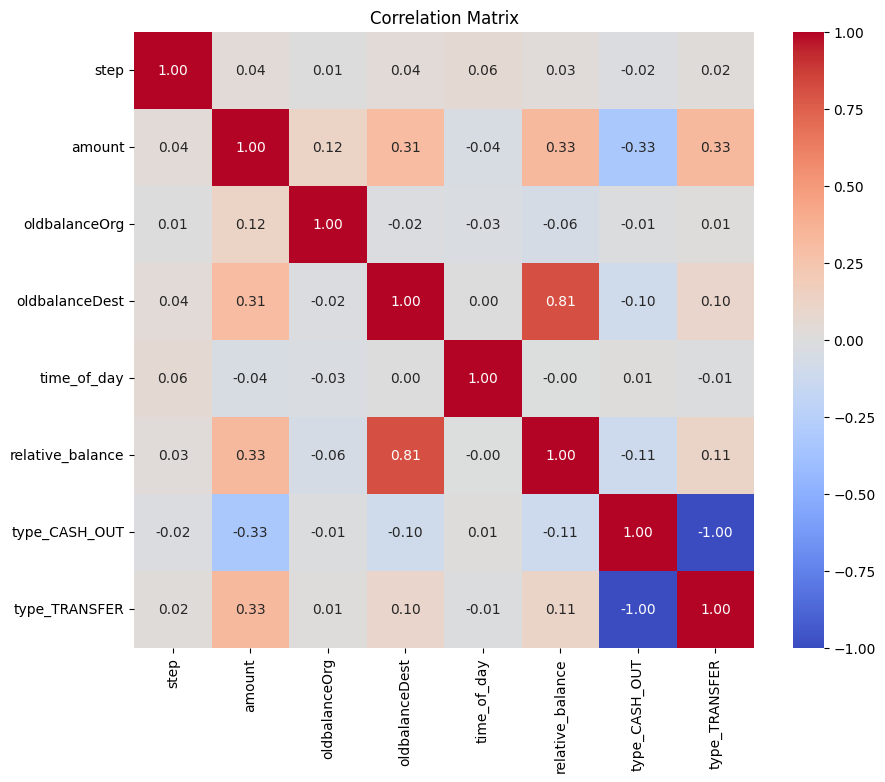

In [20]:
cov_matrix = data_full.drop(columns=['isFraud']).corr()

# Display the covariance matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()

None of these results are too suprising. Obviously the two types 'CASH_OUT' and 'TRANSFER' are going to be inversely correlated perfectly as only or the other can be true. Since **relative_balance** is directly proportional to **oldbalanceDest** it also makes sense that there is high correlation. Later on, when modeling we may chose one or the other based of off model results. 

Based off of the above EDA, I do have some predictions for which features will be most important for the model:

1) **time_of_day** - This engineered feature will have high importance due to the wildly different distrubutions of valid and fraudulent transactions. Valid transactions tend to happend during only specific time periods, where fraudulent transactions are uniform. 
2) **step** - Also has useful information due to the different distributions.
3) **relative_balance** - I'm hoping the overlap between the distributions of previous features and this one will also make it a highly predictive feature.

This is the data we I'll be using, although both clustering methods and some of the supervised learning methods will be sensitive to non scaled data. So I'll scale it here using the MinMaxScaler from sklearn (Standard scaler requires a normal distribution, but our data does not indicate this trend). I'll also create a train, test split of 80% - 20%. 

In [21]:
mmscaler = MinMaxScaler()
data_full_scaled = pd.DataFrame(mmscaler.fit_transform(data_full.drop(columns=['isFraud'])), columns=data_full.drop(columns=['isFraud']).columns)

X_train, X_test, y_train, y_test = train_test_split(data_full_scaled, data_full['isFraud'], test_size=.2)

### Modeling

For the unsupervised preprocessing steps I would like to try clustering using two methods:
1) k-means clustering
2) DBSCAN

Then this will be used as an input to these three machine learning models:
1) Logisting Regression
2) Random Forest
3) SVG


#### K-Means Clustering

K-Means Clustering can be usefull as a preprocessing and/or categorization step for data that easily falls into clusters. Because the finacial data we are dealing with isn't going to fall neatly within clusters, there may be some issues with the usefulness of the model. K-Means is sensitive to scaling, as distance metrics are used to place each data point into a cluster. When data is not scaled properly, features that span larger ranges will have more impact on the final categorization than features that don't. For example our **time_of_day** feature is very important for predictiveness, however it will be overshadowed by the vastly greater **amount** feature, which doesn't hold as nice of a distribution between fraud and valid transactions. Because the data isn't going gaussian distributed, we will use the sklearn MinMaxScaler to scale all features between [0, 1] prior to the fit.

Additionally, picking the right $k$ value is not trivial. We cannot just set $k=2$ and hope that fraud will be predicted immediately. Instead, some manual inspection of the results will be needed. One thing we might look for in a preprocessing step is for is categories which lend themselves to relatively lower or higher fraud. If this distinction can be made, these categories can be passed to future models which will aid in the prediction. 

In order to pick a $k$ value, I will loop from 2 to 30 and check the mean fraud in each of the generated clusters. I will also be taking a look at the plot of the Sum of Squared Errors from each point to it's centroid. The plot can let us know when there are diminishing returns on increasing the $k$ value further.

In [22]:
sse = []
max_seperation = []


for i in range(2, 30):
    km_model = KMeans(n_clusters=i, random_state=8)

    km_data = X_train.copy()

    prediction = km_model.fit(km_data)
    km_data['cluster'] = prediction.labels_
    km_data['isFraud'] = y_train
    sse_value = prediction.inertia_

    fraud_cluster_summary = km_data.groupby('cluster')['isFraud'].mean()

    sse.append(sse_value)
    max_seperation.append(max(fraud_cluster_summary))


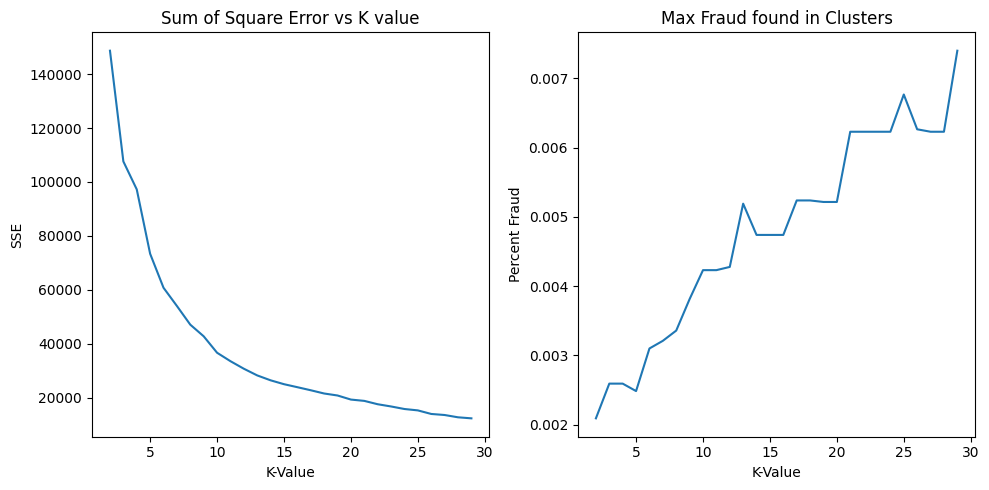

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(2, 30), sse)
ax1.set_title("Sum of Square Error vs K value")
ax1.set_ylabel("SSE")
ax1.set_xlabel("K-Value")


ax2.plot(range(2, 30), max_seperation)
ax2.set_title("Max Fraud found in Clusters")
ax2.set_ylabel("Percent Fraud")
ax2.set_xlabel("K-Value")

plt.tight_layout()
plt.show()



Something interesting happens around K >= 20 with where the categorization of Fraud within each cluster jumps. So picking $k=22$ let's examine a little closer the cluster behaviour. In terms of SSE this is a little passed the elbow, but our mean fraud metric is going to be more important for prediction. K Means Clustering does inherintly have some randomness to it, but it is at this $k~=20$ point where these huge jumps of Fraud within 1 cluster are found. I ran the above code a couple times with different random states to see this, and eventually picket **random_state** = 8 for the demonstration.

In [24]:
km_model = KMeans(n_clusters=22, random_state=8)
km_data = X_train.copy()
prediction = km_model.fit(km_data)


km_data['cluster'] = prediction.labels_
km_data['isFraud'] = y_train
sse_value = prediction.inertia_

# Calculate the mean of 'isFraud' per cluster
fraud_cluster_summary = km_data.groupby('cluster')['isFraud'].mean()

# Calculate the count of observations per cluster
cluster_counts = km_data['cluster'].value_counts().sort_index()

# Combine the mean and counts into a single DataFrame
fraud_cluster_summary = pd.DataFrame({
    'fraud_mean': fraud_cluster_summary,
    'count': cluster_counts,
    'greater_than_average': fraud_cluster_summary > y_train.mean(),
    'less_than_quarter_average': fraud_cluster_summary < y_train.mean()/4
})

print(fraud_cluster_summary.sort_values(by='fraud_mean'))
print("Compared to the mean fraud across the entire thing:", y_train.mean())

         fraud_mean   count  greater_than_average  less_than_quarter_average
cluster                                                                     
20         0.000473   76274                 False                       True
0          0.000551   72601                 False                       True
3          0.000583   87813                 False                       True
11         0.000627   13798                 False                       True
21         0.000786    7388                 False                      False
10         0.000793  178826                 False                      False
19         0.000798   13968                 False                      False
2          0.000840  199478                 False                      False
5          0.000914  195329                 False                      False
12         0.001153   12125                 False                      False
15         0.001180   79051                 False                      False

We can see that clusters 7, 12, and 9 all have basically very little fraud within them. Whereas clusters 17, 19, and 18 have elevated levels of fraud. Theoritcally we can one hot encode all of these cluster prior to passing them into a supervised machine learning model, however I'm going to apply a transform instead which will give each cluster a score based on the mean instead. That way the encoding will represent the relative levels of fraud within the cluster that the observation is part of. This will save us from creating 22 new features, and instead will just be one new feature called **relative_fraud_km**

In [25]:
relative_fraud_map = {index: row['fraud_mean']/y_train.mean() for index, row in fraud_cluster_summary.iterrows()}

**relative_fraud_km** will be added later to the supervised models to see if it will boost performance compared to the base models.

### DBSCAN

DBSCAN is another clustering method that clusters points together that are close enough to each other, within some distance $\epsilon$. It is commonly used in outlier detection and thus may be well suited for fraud detection in financial situations as well. There are two parameters that DBSCAN needs specified:

1) $\epsilon$ - The maximum distance between two samples for one to be considered as in the neighborhood of the other
2) $Min_{s}$ - The number of samples in a neighborhood for a point to be considered as a core point. 

Core points are used as a basis to expand and combine clusters. Points that are not core points are either border points (ones on the edge of a cluster), or are noise points (anomoulous points). The choice of each of these is important and will widely vary how DBSCAN clusters points. 

Selection of the $\epsilon$ parameter will be done first using a method found from this academic paper[2]. The procedure computes the distanes between each point and it's closest neighbor. Plotting these distances in acending order, $\epsilon$ can be choosen where the greatest curvature happens

Before any computation happens, the dimensionality of our data in conjuction with the amount of points we have, means that this algorithm will run fairly long (I know from trial and error). One of the biggest techniques to reduce this runtime is reducing dimensionality. We can reduce dimensionality by running a PCA beforehand and pulling the top 3 principle components, and then running the clustering on those.

In [26]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

Then the nearest neighbor technique:

In [27]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

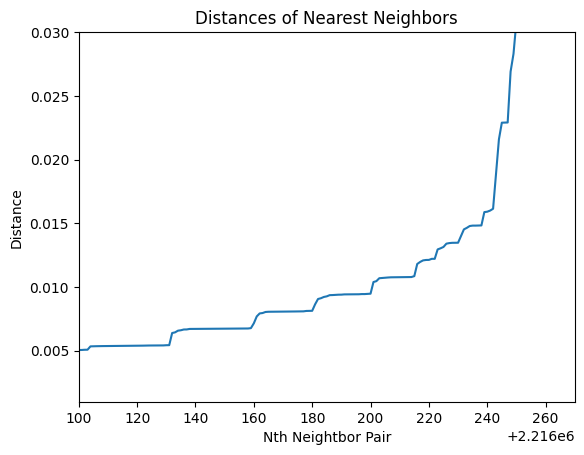

In [32]:
plt.plot(distances)
#plt.xlim([2.215e6, 2.2165e6])
plt.ylim([.001, .03])
plt.xlim([2.2161e6, 2.21627e6])
plt.title('Distances of Nearest Neighbors')
plt.ylabel('Distance')
plt.xlabel('Nth Neightbor Pair')
#plt.yscale('log')
plt.show()

We can see by the graph above that the highest rate of curvature is around .013.

The other parameter $Min_{s}$ can be chosen based on the number of dimension of the data + 1, as a starting point. This can also be varied all the way up to $Min_{s} = 2D$, where $D$ is the dimensionality of the features. Our PCA data has $D=3$, so I'll set the $Min_{s} = 4$.

In [33]:
pca_sampled = pd.DataFrame(X_pca)
# Ensure the index is aligned before adding 'isFraud'
# Add the 'isFraud' column
pca_sampled.index = y_train.index
pca_sampled['isFraud'] = y_train
#pca_sampled['isFraud'] = X_train['isFraud']

pca_sampled = pca_sampled.sample(100000, replace=False) # Cannot run DBSCAN on entire dataset

In [34]:

db = DBSCAN(eps=.013, min_samples=4, n_jobs=-1)
dbscan_labels = db.fit(pca_sampled.drop(columns=['isFraud'])).labels_

In [35]:
(dbscan_labels == -1).sum()

np.int64(369)

So we have ~369 examples of anomolies in the DBSCAN when using PCA. Unfortunately this doesn't go over the entire dataset, but it isn't really possible with the amount of data present. DBSCAN scales as $O(n^2)$ in the worst case scenario, and going from 100,000 points to the more than 2,000,000 is not doable on my machine. Regardless let's check if there is any collection of points that has higher levels of fraud.

In [36]:
pca_sampled['cluster'] = dbscan_labels
# Calculate the mean of 'isFraud' per cluster
fraud_cluster_summary = pca_sampled.groupby('cluster')['isFraud'].mean()

# Calculate the count of observations per cluster
cluster_counts = pca_sampled['cluster'].value_counts().sort_index()

# Combine the mean and counts into a single DataFrame
fraud_cluster_summary = pd.DataFrame({
    'fraud_mean': fraud_cluster_summary,
    'count': cluster_counts,
})
fraud_cluster_summary.sort_values(by='fraud_mean', ascending=False).head(20)

,fraud_mean,count
cluster,,
670,0.500000,4
634,0.500000,4
578,0.500000,4
592,0.500000,4
-1,0.433604,369
689,0.250000,4
675,0.250000,4
687,0.250000,4
672,0.250000,8


Even though the top groups are grouping fraud very efficiently, the fall off is really quick. This in conjuction with the vast amount of transaction data means that DBSCAN is not well suited for this problem and may not be a good indication of if there is fraud or not. The top 20 by fraud mean does contain the anomoulous group of $-1$, so with a fast enough computer, and subset sampling DBSCAN could potentially be used to look at this anomoulous group more closely. This is as far as I will go with DBSCAN unfortunately, as my computer would take too long to process everything.

### Supervised Models

I'll only take a look at two models here: Logistic Regression and Random Forest but I'll specifically be looking at the differences between including the K-means clustering and not including it.

#### Logistic Regression

For logistic regression I'll be using the built in LogisticRegression model from `sklearn`. The only thing I'll modify is the *class_weight* will be 'balanced' due to the limited number of fraudulent samples. We would have near perfect accuracy if we didn't set this parameter, but we would also essentially not be catching any fraud. I'll measure a variety of different scores as well.

In [37]:
results = pd.DataFrame(columns=['model', 'train_acc_score', 'train_rec_score', 'train_prec_score', 'train_f1_score', 'test_acc_score', 'test_rec_score', 'test_prec_score', 'test_f1_score'])
X_train_km = X_train.copy()
X_train_km['category'] = km_model.predict(X_train)
X_train_km['category'] = X_train_km['category'].apply(lambda x: relative_fraud_map[x])

X_test_km = X_test.copy()
X_test_km['category'] = km_model.predict(X_test)
X_test_km['category'] = X_test_km['category'].apply(lambda x: relative_fraud_map[x])


In [38]:
lr_no_km = LogisticRegression(class_weight='balanced')
lr_no_km_model =lr_no_km.fit(X_train, y_train)
yp_train = lr_no_km_model.predict(X_train)
yp_test = lr_no_km_model.predict(X_test)


train_acc = accuracy_score(y_train, yp_train)
train_rec = recall_score(y_train, yp_train)
train_prec = precision_score(y_train, yp_train)
train_f1 = f1_score(y_train, yp_train)

test_acc = accuracy_score(y_test, yp_test)
test_rec = recall_score(y_test, yp_test)
test_prec = precision_score(y_test, yp_test)
test_f1 = f1_score(y_test, yp_test)

results.loc[len(results)] = ['Basic Logistic', train_acc, train_rec, train_prec, train_f1, test_acc, test_rec, test_prec, test_f1]

results.head()



,model,train_acc_score,train_rec_score,train_prec_score,train_f1_score,test_acc_score,test_rec_score,test_prec_score,test_f1_score
0,Basic Logistic,0.925331,0.841471,0.032843,0.063219,0.925926,0.837924,0.03107,0.059919


Next up, let's see what happens when we add the preprocessing step of the kmeans classifier:

In [39]:
lr_km = LogisticRegression(class_weight='balanced')

lr_km_model =lr_km.fit(X_train_km, y_train)
yp_train = lr_km_model.predict(X_train_km)
yp_test = lr_km_model.predict(X_test_km)


train_acc = accuracy_score(y_train, yp_train)
train_rec = recall_score(y_train, yp_train)
train_prec = precision_score(y_train, yp_train)
train_f1 = f1_score(y_train, yp_train)

test_acc = accuracy_score(y_test, yp_test)
test_rec = recall_score(y_test, yp_test)
test_prec = precision_score(y_test, yp_test)
test_f1 = f1_score(y_test, yp_test)

results.loc[len(results)] = ['KM Preprocess Logistic', train_acc, train_rec, train_prec, train_f1, test_acc, test_rec, test_prec, test_f1]

results.head()

,model,train_acc_score,train_rec_score,train_prec_score,train_f1_score,test_acc_score,test_rec_score,test_prec_score,test_f1_score
0,Basic Logistic,0.925331,0.841471,0.032843,0.063219,0.925926,0.837924,0.031070,0.059919
1,KM Preprocess Logistic,0.925584,0.842526,0.032990,0.063494,0.926057,0.839206,0.031169,0.060106


### Random Forest Model

Once again I'll compare the standard `sklearn` RandomForestClassifier with and without the additional feature.

In [40]:
rf_no_km = RandomForestClassifier(50, n_jobs=-1)
rf_no_km_model =rf_no_km.fit(X_train, y_train)
yp_train = rf_no_km_model.predict(X_train)
yp_test = rf_no_km_model.predict(X_test)


train_acc = accuracy_score(y_train, yp_train)
train_rec = recall_score(y_train, yp_train)
train_prec = precision_score(y_train, yp_train)
train_f1 = f1_score(y_train, yp_train)

test_acc = accuracy_score(y_test, yp_test)
test_rec = recall_score(y_test, yp_test)
test_prec = precision_score(y_test, yp_test)
test_f1 = f1_score(y_test, yp_test)

results.loc[len(results)] = ['Basic Random Forest', train_acc, train_rec, train_prec, train_f1, test_acc, test_rec, test_prec, test_f1]

results.head()


,model,train_acc_score,train_rec_score,train_prec_score,train_f1_score,test_acc_score,test_rec_score,test_prec_score,test_f1_score
0,Basic Logistic,0.925331,0.841471,0.032843,0.063219,0.925926,0.837924,0.031070,0.059919
1,KM Preprocess Logistic,0.925584,0.842526,0.032990,0.063494,0.926057,0.839206,0.031169,0.060106
2,Basic Random Forest,0.999786,0.928571,1.000000,0.962963,0.999060,0.699552,0.954545,0.807394


And now for the preprocessing step:

In [41]:
rf_km = RandomForestClassifier(50, n_jobs=-1)


rf_km_model =rf_km.fit(X_train_km, y_train)
yp_train = rf_km_model.predict(X_train_km)
yp_test = rf_km_model.predict(X_test_km)


train_acc = accuracy_score(y_train, yp_train)
train_rec = recall_score(y_train, yp_train)
train_prec = precision_score(y_train, yp_train)
train_f1 = f1_score(y_train, yp_train)

test_acc = accuracy_score(y_test, yp_test)
test_rec = recall_score(y_test, yp_test)
test_prec = precision_score(y_test, yp_test)
test_f1 = f1_score(y_test, yp_test)

results.loc[len(results)] = ['KM Preprocess Random Forest', train_acc, train_rec, train_prec, train_f1, test_acc, test_rec, test_prec, test_f1]

## Results

Here are the results for this problem:

In [42]:
results.head()

,model,train_acc_score,train_rec_score,train_prec_score,train_f1_score,test_acc_score,test_rec_score,test_prec_score,test_f1_score
0,Basic Logistic,0.925331,0.841471,0.032843,0.063219,0.925926,0.837924,0.031070,0.059919
1,KM Preprocess Logistic,0.925584,0.842526,0.032990,0.063494,0.926057,0.839206,0.031169,0.060106
2,Basic Random Forest,0.999786,0.928571,1.000000,0.962963,0.999060,0.699552,0.954545,0.807394
3,KM Preprocess Random Forest,0.999968,0.989301,1.000000,0.994622,0.999108,0.727739,0.942739,0.821403


I've included 4 different scorings for both the training set and the test set. For financial fraud detection, just comparing accuracy is not enough, because fraudulent transactions are not as common as valid transactions, but there is a cost associated with missing these transactions. Precision is important as it dictates how frequently are users are going to be blocked when there is a valid transaction, but our model stops it from going through. Recall is also important, because when false negatives are let through the system, customers can loose a lot of money from their accounts. Reversing these transactions get's difficult, and could be a cost that either the consumer or our (fictional) company would have to eat. F1 score is a good balanec between these two metrics, but taking a look at all 3 is important.

Random Forests significantly out perform the Logist Regression models. There is some overfitting happening for the random forest models, as there is a fairly large difference between the F1 score across the train and test dataset. This happens even with our over 2 million training points, however the test set still achieves good scores. It can also be potentially addressed by tuning hyperparameters suchs as **max_depth** and **leaf_node_size**, however the goal of this project was moreso to see the effect of the unsupervised pre-processing step.

For the Logistic Model, there doesn't seem to be a significant improvement between the Basic Model and the one that has K-means categories. This is somewhat suprising to me, as the additional information seems like it should matter a little more.

For the Random Forest however, there is a noticable difference in recall, which is getting better at not having many false negatives. This is likely due to some categories containing either fewer levels of fraud or elevated levels of fraud. The model can translate this to make a better prediction on the dataset. Because of the feature splitting that Random Forests use, it can take larger advantage of these categories. The improvement to F1 score isn't a whole lot (from 78.2% to 80.8% with preprocessing), however the improvement to recall does make this worth it (65.8% to 70.8%).

Overall, these results show that using unsupervised learning as a preproccessing step can be quite effective in increasing model performance. 

The way I implemented this preprocessing is unique, and future investigations could look into what others have done in preprocessing classification. I would like to take a second look at DBSCAN, or other density based scans, but unfortunately it didn't work out well for this specfic dataset. The large amount of points lend to technqiues that have smaller time complexities. There are more complicated data pipelines that could work with DBSCAN however[3]. I also wanted to try SVM methods, however with time complexity of $O(n^3)$ this is also not managable. 

Finally, the dataset used was generated for very specific types of financial transactions (namely mobile transactions in Africa). Further investigation into different transaction scenarios would produce interesting results also. Things like credit cards transactions, where location could be taken into affect or entered payment fields. Overall, the database was quite simplistic. 

Bibliography:

[1] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

[2] Nadia Rahmah and Imas Sukaesih Sitanggang 2016 IOP Conf. Ser.: Earth Environ. Sci. 31 012012

‌[3] “KNIME for Finance: Fraud Detection Using DBSCAN | KNIME.” KNIME, 2024, www.knime.com/blog/fraud-detection-using-dbscan. Accessed 19 Aug. 2024.



